In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [2]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CPU


In [3]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [4]:
src_base_path = Path('1')
dest_base_path = Path('images')
cats = ['赤链蛇', '翠青蛇','黑眉锦蛇','乌梢蛇']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)


Category: 赤链蛇
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Category: 翠青蛇
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Category: 黑眉锦蛇
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Category: 乌梢蛇
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Overall Dataset Statistics:
Train set: 120 files
Valid set: 40 files
Test set: 40 files


In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64)

c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20044 (\N{CJK UNIFIED IDEOGRAPH-4E4C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26786 (\N{CJK UNIFIED IDEOGRAPH-68A2}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 34503 (\N{CJK UNIFIED IDEOGRAPH-86C7}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 40657 (\N{CJK UNIFIED IDEOGRAPH-9ED1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30473 (\N{CJK UNIFIED IDEOGRAPH-7709}) missing from font(s) DejaVu Sans.
  func(*a

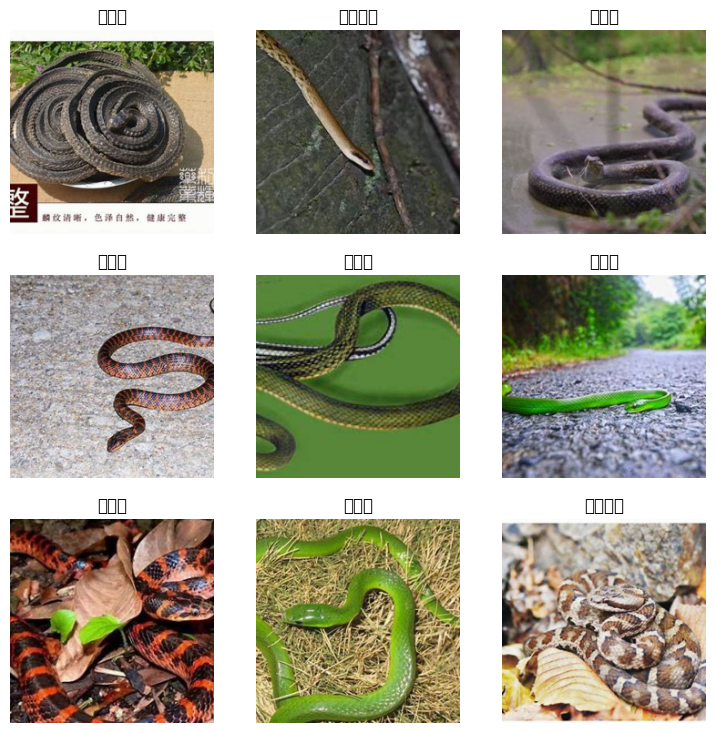

In [6]:
dls.show_batch()

In [7]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [8]:
learn = vision_learner(dls, resnet34, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

In [9]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time
0,2.293082,5.554908,0.250000,00:05


Better model found at epoch 0 with valid_loss value: 5.55490779876709.


epoch,train_loss,valid_loss,accuracy,time
0,2.149890,4.126441,0.250000,00:06
1,1.986113,3.129924,0.275000,00:06
2,1.799017,2.387578,0.375000,00:06
3,1.684406,1.827881,0.450000,00:06
4,1.542000,1.427632,0.550000,00:06
5,1.435638,1.185602,0.575000,00:06
6,1.298830,1.000819,0.650000,00:06
7,1.192866,0.858932,0.725000,00:06
8,1.118550,0.767587,0.750000,00:06
9,1.023662,0.699034,0.775000,00:06


Better model found at epoch 0 with valid_loss value: 4.12644100189209.
Better model found at epoch 1 with valid_loss value: 3.1299235820770264.
Better model found at epoch 2 with valid_loss value: 2.387578010559082.
Better model found at epoch 3 with valid_loss value: 1.8278814554214478.
Better model found at epoch 4 with valid_loss value: 1.427632212638855.
Better model found at epoch 5 with valid_loss value: 1.185602068901062.
Better model found at epoch 6 with valid_loss value: 1.0008187294006348.
Better model found at epoch 7 with valid_loss value: 0.8589321374893188.
Better model found at epoch 8 with valid_loss value: 0.7675874829292297.
Better model found at epoch 9 with valid_loss value: 0.6990339756011963.
Better model found at epoch 10 with valid_loss value: 0.6468284726142883.
Better model found at epoch 11 with valid_loss value: 0.6071778535842896.
Better model found at epoch 12 with valid_loss value: 0.584428071975708.
Better model found at epoch 13 with valid_loss value: 

In [10]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.7749999761581421.


In [11]:
loss

0.7699466943740845

In [12]:
acc

0.7749999761581421

c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 20044 (\N{CJK UNIFIED IDEOGRAPH-4E4C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 26786 (\N{CJK UNIFIED IDEOGRAPH-68A2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 34503 (\N{CJK UNIFIED IDEOGRAPH-86C7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 32736 (\N{CJK UNIFIED IDEOGRAPH-7FE0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\fastai\interpret.py:151: UserWarning: Glyph 38738 (\N{CJK UNIFIED IDEOGRAPH-9752}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\l

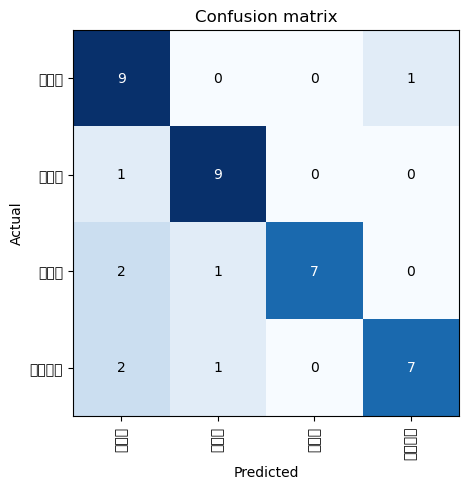

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

         乌梢蛇       0.64      0.90      0.75        10
         翠青蛇       0.82      0.90      0.86        10
         赤链蛇       1.00      0.70      0.82        10
        黑眉锦蛇       0.88      0.70      0.78        10

    accuracy                           0.80        40
   macro avg       0.83      0.80      0.80        40
weighted avg       0.83      0.80      0.80        40



c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20044 (\N{CJK UNIFIED IDEOGRAPH-4E4C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26786 (\N{CJK UNIFIED IDEOGRAPH-68A2}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 34503 (\N{CJK UNIFIED IDEOGRAPH-86C7}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 40657 (\N{CJK UNIFIED IDEOGRAPH-9ED1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\liuxu\anaconda3\envs\datascience\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30473 (\N{CJK UNIFIED IDEOGRAPH-7709}) missing from font(s) DejaVu Sans.
  func(*a

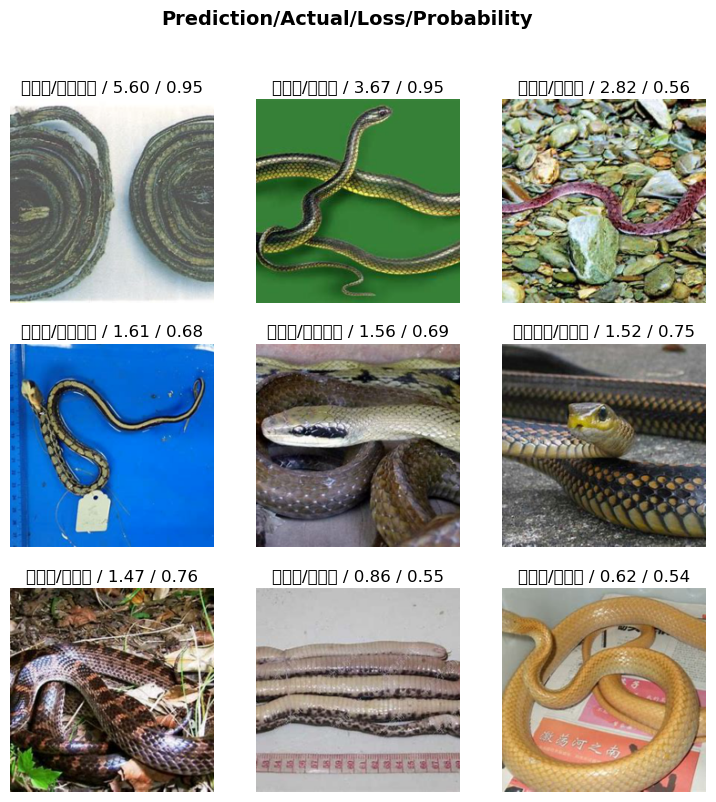

In [15]:
interp.plot_top_losses(9)

In [16]:
learn.export('snake.pkl')